## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

# Lecture 2: Global and Local Explanations of a Constrained Model

#### Global hyperpameters

In [1]:
SEED                    = 12345   # global random seed for better reproducibility

#### Python imports and inits

In [2]:
from rmltk import explain                                         # simple module for training, explaining, and eval
import h2o                                                        # import h2o python bindings to h2o java server
import numpy as np                                                # array, vector, matrix calculations
import operator                                                   # for sorting dictionaries
import pandas as pd                                               # DataFrame handling
from scipy.special import expit                                   # for inverse logit
import shap                                                       # for visualizing Shapley values
import time                                                       # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

/home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp05wq1dqe
  JVM stdout: /tmp/tmp05wq1dqe/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmp05wq1dqe/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 months and 1 day !!!
H2O cluster name:,H2O_from_python_patrickh_sxwivx
H2O cluster total nodes:,1
H2O cluster free memory:,21.33 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


#### Start global timer

In [3]:
big_tic = time.time()

## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input features: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The steps below  ...

#### Import data and reformat

In [4]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
Notice that demographic features are not used as model inputs.

In [5]:
# assign target and inputs for models
y_name = 'DEFAULT_NEXT_MONTH'
x_names = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4']
print('y_name =', y_name)
print('x_names =', x_names)

y_name = DEFAULT_NEXT_MONTH
x_names = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4']


#### Split data into training and validation partitions

In [6]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 20946, columns = 25
Validation data rows = 9054, columns = 25


## 2. Load Pre-trained Monotonic GBM

In [7]:
# load saved best model from lecture 1 
best_mgbm = h2o.load_model('best_mgbm')

# display model details
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  best_mgbm


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,6943.0,3.0,3.0,3.0,5.0,8.0,7.369565




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13637719864300343
RMSE: 0.3692928358945018
LogLoss: 0.4351274080189972
Mean Per-Class Error: 0.2913939696264273
AUC: 0.7716491282246187
pr_auc: 0.5471826859054356
Gini: 0.5432982564492375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21968260039166268: 

,,0,1,Error,Rate
0,0,13482.0,2814.0,0.1727,(2814.0/16296.0)
1,1,1907.0,2743.0,0.4101,(1907.0/4650.0)
2,Total,15389.0,5557.0,0.2254,(4721.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219683,0.537474,248.0
1,max f2,0.127859,0.630227,329.0
2,max f0point5,0.446699,0.583033,147.0
3,max accuracy,0.446699,0.821493,147.0
4,max precision,0.950247,1.000000,0.0
5,max recall,0.050609,1.000000,395.0
6,max specificity,0.950247,1.000000,0.0
7,max absolute_mcc,0.325159,0.413494,194.0
8,max min_per_class_accuracy,0.177542,0.698495,281.0
9,max mean_per_class_accuracy,0.219683,0.708606,248.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010074,0.813927,3.607883,3.607883,0.800948,0.843446,0.800948,0.843446,0.036344,0.036344,260.788259,260.788259
1,,2,0.020338,0.795575,3.519808,3.563432,0.781395,0.805153,0.791080,0.824119,0.036129,0.072473,251.980795,256.343177
2,,3,0.030316,0.763679,3.405328,3.511394,0.755981,0.783970,0.779528,0.810905,0.033978,0.106452,240.532798,251.139446
3,,4,0.040008,0.715138,3.261891,3.450954,0.724138,0.739815,0.766110,0.793684,0.031613,0.138065,226.189099,245.095388
4,,5,0.050081,0.664416,3.116869,3.383755,0.691943,0.686695,0.751192,0.772164,0.031398,0.169462,211.686898,238.375473
5,,6,0.100019,0.543384,2.859463,3.121984,0.634799,0.601794,0.693079,0.687101,0.142796,0.312258,185.946339,212.198445
6,,7,0.150005,0.366237,2.224293,2.822849,0.493792,0.446951,0.626671,0.607076,0.111183,0.423441,122.429306,182.284922
7,,8,0.205672,0.292765,1.595510,2.490659,0.354202,0.312777,0.552925,0.527422,0.088817,0.512258,59.551043,149.065864
8,,9,0.301251,0.196648,1.174504,2.073077,0.260739,0.234499,0.460222,0.434485,0.112258,0.624516,17.450421,107.307684
9,,10,0.400029,0.173817,0.864327,1.774604,0.191880,0.184844,0.393961,0.372842,0.085376,0.709892,-13.567284,77.460410




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

,,0,1,Error,Rate
0,0,6093.0,975.0,0.1379,(975.0/7068.0)
1,1,863.0,1123.0,0.4345,(863.0/1986.0)
2,Total,6956.0,2098.0,0.203,(1838.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273973,0.549951,217.0
1,max f2,0.147835,0.634488,307.0
2,max f0point5,0.436620,0.590736,153.0
3,max accuracy,0.456963,0.825271,147.0
4,max precision,0.947069,1.000000,0.0
5,max recall,0.045106,1.000000,397.0
6,max specificity,0.947069,1.000000,0.0
7,max absolute_mcc,0.347246,0.429999,184.0
8,max min_per_class_accuracy,0.181585,0.709970,275.0
9,max mean_per_class_accuracy,0.230518,0.714339,240.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011155,0.815010,3.295055,3.295055,0.722772,0.839858,0.722772,0.839858,0.036757,0.036757,229.505549,229.505549
1,,2,0.020543,0.795575,3.700764,3.480460,0.811765,0.805631,0.763441,0.824217,0.034743,0.071501,270.076417,248.045999
2,,3,0.030042,0.783550,3.604721,3.519749,0.790698,0.792441,0.772059,0.814170,0.034240,0.105740,260.472142,251.974853
3,,4,0.040093,0.743192,3.005876,3.390927,0.659341,0.761335,0.743802,0.800925,0.030211,0.135952,200.587630,239.092657
4,,5,0.050033,0.697702,3.444512,3.401573,0.755556,0.723091,0.746137,0.785461,0.034240,0.170191,244.451158,240.157260
5,,6,0.101281,0.553193,3.104777,3.251394,0.681034,0.614736,0.713195,0.699075,0.159114,0.329305,210.477654,225.139444
6,,7,0.150320,0.383564,2.187046,2.904171,0.479730,0.466067,0.637032,0.623061,0.107251,0.436556,118.704581,190.417123
7,,8,0.200022,0.296915,1.580423,2.575244,0.346667,0.327817,0.564881,0.549698,0.078550,0.515106,58.042296,157.524427
8,,9,0.301303,0.203539,1.133514,2.090616,0.248637,0.250648,0.458578,0.449174,0.114804,0.629909,13.351366,109.061561
9,,10,0.403468,0.176970,0.961068,1.804595,0.210811,0.187190,0.395839,0.382836,0.098187,0.728097,-3.893198,80.459549




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-25 11:49:11,41.173 sec,0.0,0.415591,0.529427,0.500000,0.000000,1.000000,0.778001,0.413815,0.526105,0.500000,0.000000,1.000000,0.780649
1,,2020-05-25 11:49:11,41.197 sec,1.0,0.407822,0.511864,0.716131,0.534717,3.474912,0.236370,0.405538,0.507496,0.726731,0.537125,3.444264,0.187652
2,,2020-05-25 11:49:11,41.218 sec,2.0,0.401483,0.498746,0.744646,0.532172,3.529706,0.228731,0.398808,0.493698,0.752909,0.534588,3.422307,0.232825
3,,2020-05-25 11:49:11,41.242 sec,3.0,0.396471,0.489013,0.748189,0.535621,3.529706,0.228636,0.393394,0.483273,0.756448,0.535692,3.422307,0.214491
4,,2020-05-25 11:49:11,41.268 sec,4.0,0.392442,0.481430,0.750121,0.535358,3.529706,0.210780,0.389030,0.475135,0.758511,0.536095,3.422307,0.217915
5,,2020-05-25 11:49:11,41.291 sec,5.0,0.389141,0.475375,0.750058,0.535198,3.529706,0.245059,0.385453,0.468630,0.758505,0.535659,3.422307,0.214270
6,,2020-05-25 11:49:11,41.313 sec,6.0,0.386399,0.470332,0.756986,0.535024,3.529706,0.243961,0.382447,0.463157,0.764722,0.536039,3.422307,0.229843
7,,2020-05-25 11:49:11,41.338 sec,7.0,0.384191,0.466316,0.757005,0.535418,3.529706,0.243961,0.380045,0.458834,0.764634,0.536411,3.422307,0.220013
8,,2020-05-25 11:49:11,41.363 sec,8.0,0.382341,0.462760,0.761106,0.540176,3.514359,0.247446,0.378063,0.455049,0.770340,0.542043,3.457524,0.204330
9,,2020-05-25 11:49:11,41.389 sec,9.0,0.380701,0.459589,0.762515,0.540880,3.518279,0.235654,0.376184,0.451464,0.772358,0.543522,3.457524,0.223548



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,PAY_0,2794.444824,1.000000,0.693347
1,PAY_2,307.237366,0.109946,0.076231
2,PAY_3,215.152893,0.076993,0.053383
3,PAY_4,155.434448,0.055623,0.038566
4,PAY_AMT1,127.986313,0.045800,0.031755
5,PAY_5,127.538628,0.045640,0.031644
6,PAY_6,102.351601,0.036627,0.025395
7,LIMIT_BAL,82.432350,0.029499,0.020453
8,PAY_AMT2,58.934135,0.021090,0.014623
9,PAY_AMT4,58.858047,0.021063,0.014604


## 3. Global Shapley Feature Importance

#### Calculate Shapley values for the MGBM predictions

In [8]:
# must convert from Pandas to H2OFrame
shap_contribs_hf = best_mgbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 1.32592475  0.19044518 -0.24705228 ...  0.09026365  0.13503307
  -1.43555605]
 [-0.32468784 -0.04222467 -0.02269689 ... -0.36542782 -0.10665477
  -1.43555605]
 [-0.26399514 -0.0377474   0.3863875  ...  0.12269209 -0.02331262
  -1.43555605]
 ...
 [-0.25929636 -0.03532003 -0.08576533 ...  0.12963703  0.17130034
  -1.43555605]
 [ 1.51308882  0.21253292  0.21623014 ...  0.07868841  0.07920039
  -1.43555605]
 [-0.32426992 -0.04222467 -0.03084931 ... -0.34815508 -0.10122114
  -1.43555605]]

Shapley contributions rows = 9054, columns = 11


#### Plot global Shapley feature importance

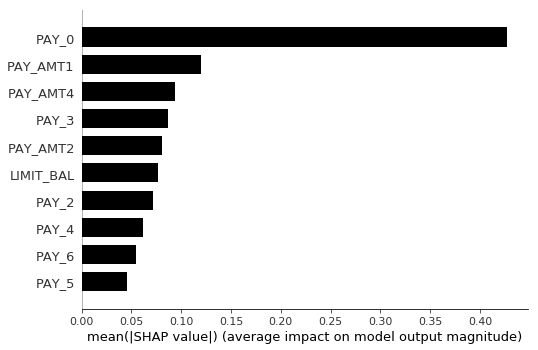

In [9]:
shap_contribs = shap_contribs_matrix[:,:-1]
shap.summary_plot(shap_contribs, x_names, plot_type='bar', color='k')

## 4. Partial dependence and ICE

#### Calculate partial dependence for each feature in best MGBM

In [10]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in x_names: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_mgbm)

#### Find some percentiles of yhat in the validation data

In [11]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_DEFAULT_NEXT_MONTH', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 6593,
 99: 17863,
 10: 23504,
 20: 15919,
 30: 1919,
 40: 22205,
 50: 12297,
 60: 1847,
 70: 12644,
 80: 29479,
 90: 7682}

#### Calculate ICE curve values

In [12]:
# loop through selected features
for xs in x_names: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['ID'] == int(mgbm_percentile_dict[i])][x_names], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']

#### Assess partial dependence and ICE for each feature in best MGBM

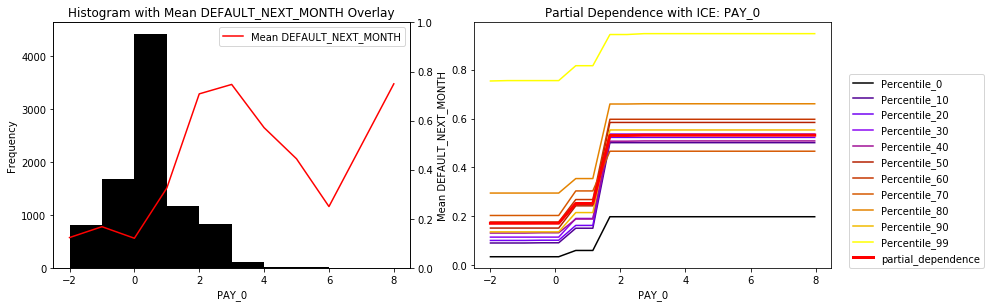

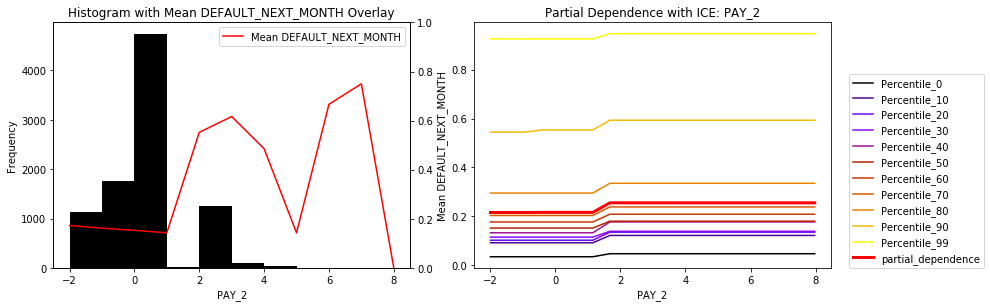

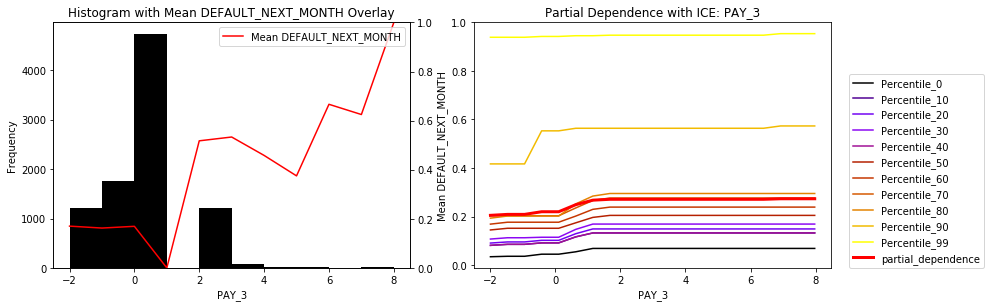

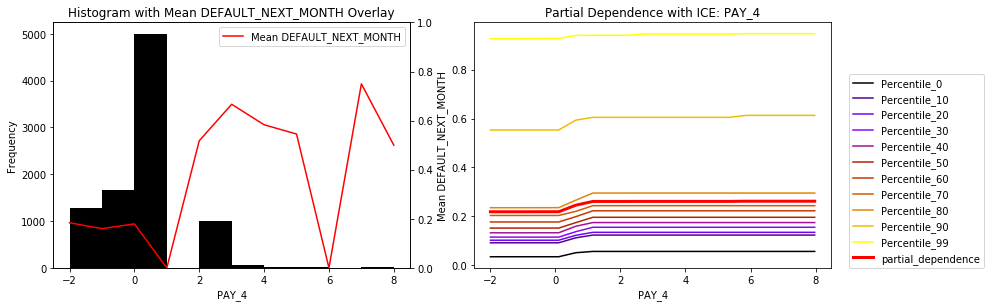

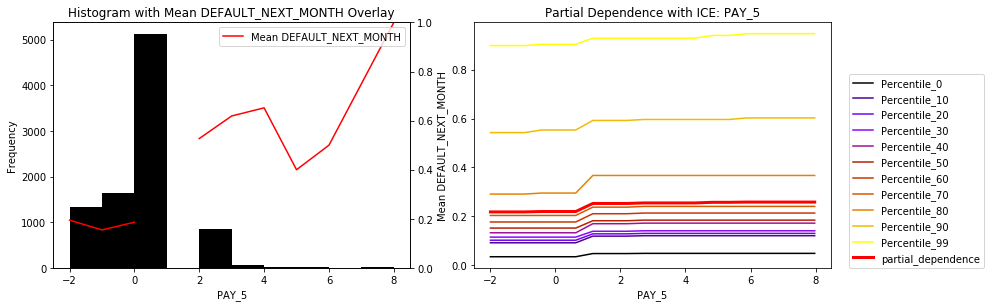

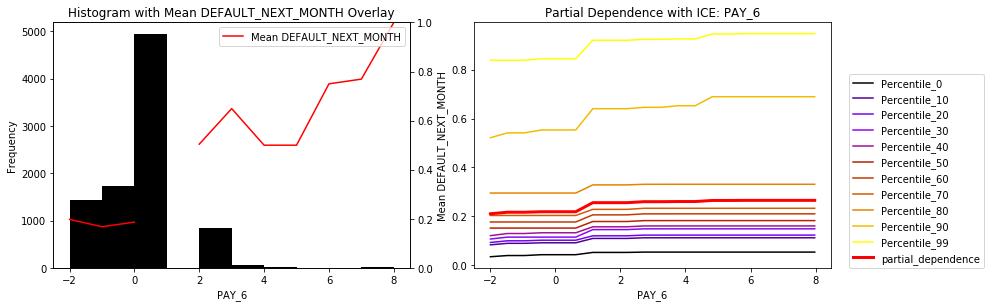

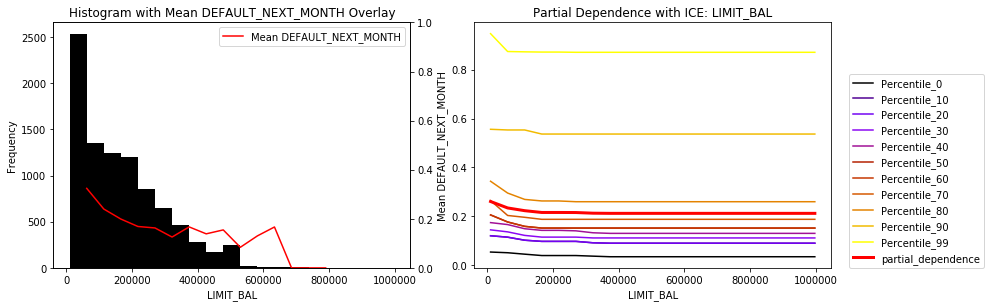

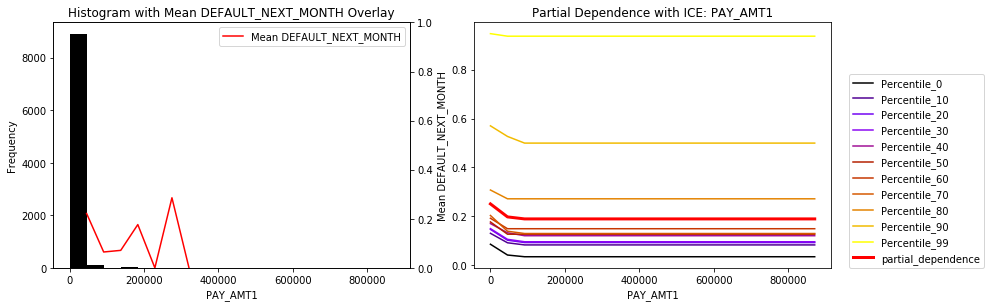

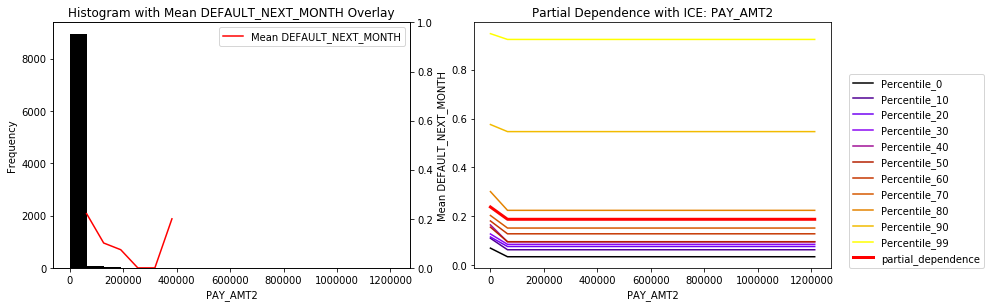

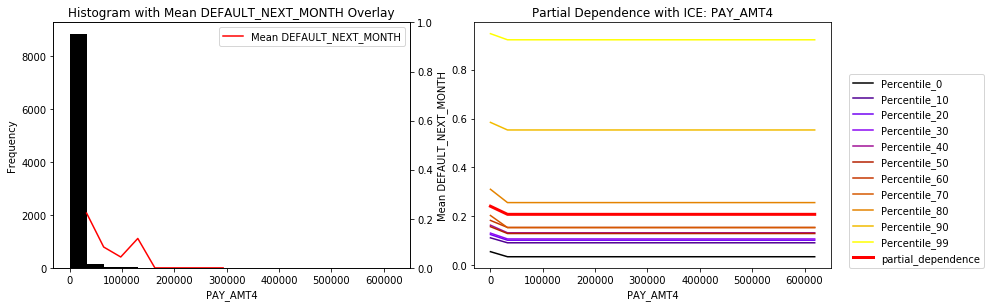

In [13]:
for xs in x_names: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, mgbm_pd_ice_dict)

## 5. Surrogate Decision Tree 

#### Train surrogate decision tree 

In [14]:
surrogate = explain.get_cv_dt(x_names, 'p_DEFAULT_NEXT_MONTH', mgbm_yhat_valid, 'best_mgbm', SEED, 'Best MGBM Flowchart')

Generated MOJO path:
 /home/patrickh/Workspace/GWU_rml/best_mgbm.zip
Discovered H2O jar path:
 /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/Workspace/GWU_rml/best_mgbm.zip -o best_mgbm.gv --title Best MGBM Flowchart
Calling external process ...
dot -Tpng best_mgbm.gv -o best_mgbm.png


####  Visualize surrogate decision tree

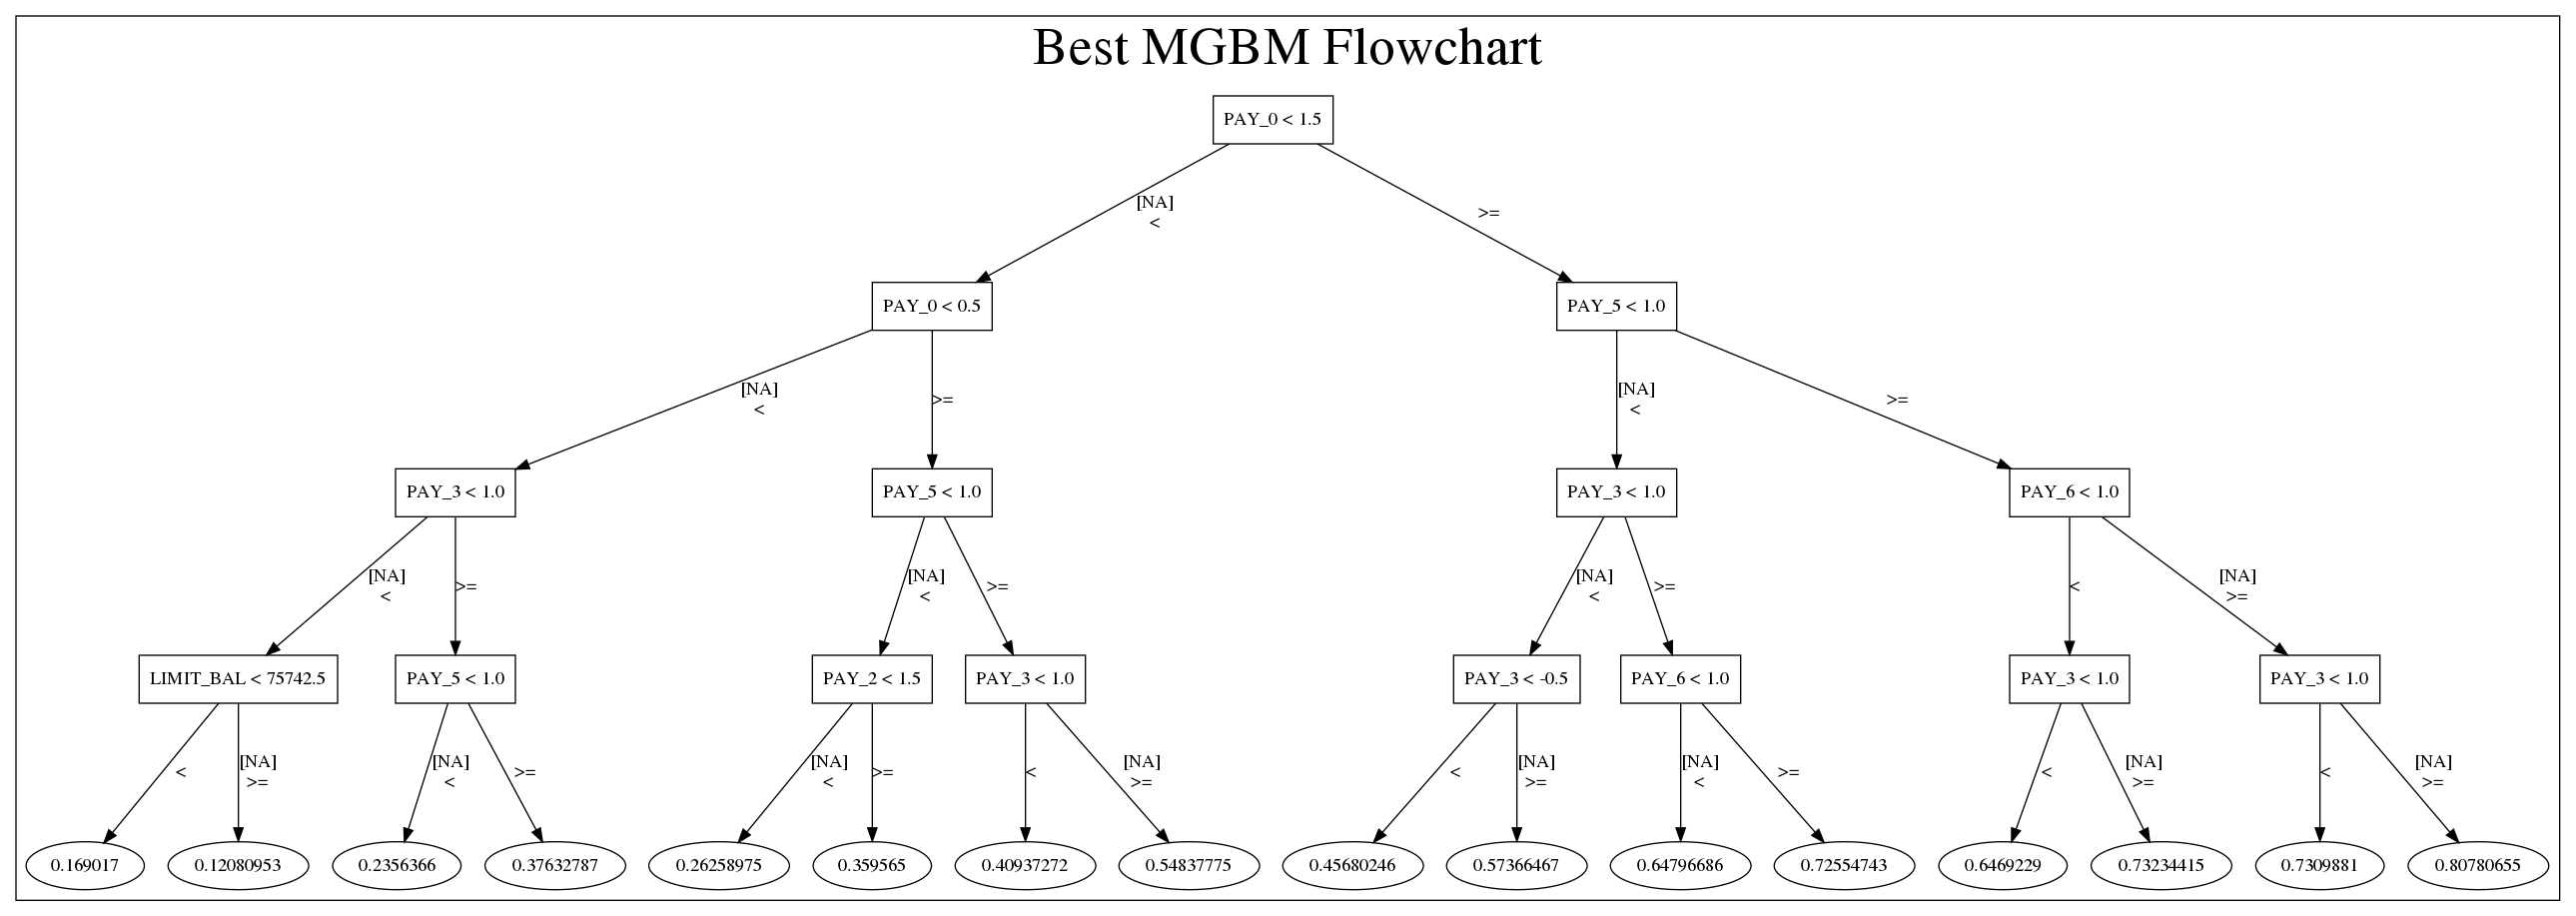

In [15]:
display(Image(('best_mgbm.png')))

#### Assess fit of surrogate decision tree

In [16]:
surrogate.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.031291604,0.0021172413,0.028846923,0.03253302,0.03249487
1,mean_residual_deviance,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
2,mse,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
3,r2,0.95078444,0.0022910195,0.9532509,0.9503795,0.94872284
4,residual_deviance,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
5,rmse,0.041381575,0.0014960271,0.03968063,0.04197092,0.042493176
6,rmsle,0.033517655,0.0014647902,0.031826653,0.034331735,0.03439458


## 6. Local Shapley Explanations

#### Create data structure for local coefficients

In [17]:
local_coef_dict = {10: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names)}

#### Create mapping between validation set ID and Shapley value array indices

In [18]:
# validation data IDs are from data
# Shapley contribs are indexed from 0, like any numpy array
valid_idx_map = valid['ID'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     1
1     7
2     9
3    11
4    12
Name: ID, dtype: int64

#### Calculate local contributions for best MGBM at three percentiles of p_DEFAULT_NEXT_MONTH

In [19]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Shapley Contribution'], index=x_names)
        local_coef_dict[percentile]['Shapley Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

#### Plot Shapley contributions at three percentiles of p_DEFAULT_NEXT_MONTH

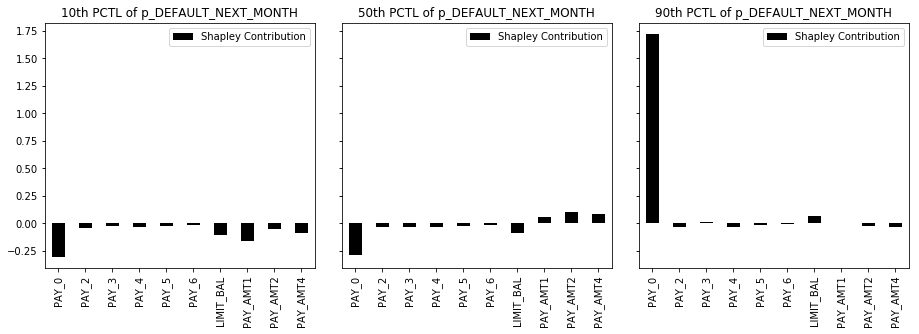

In [20]:
# initialize a three-pane plot
# with shared y-axis
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# pane 1
_ = local_coef_dict[10].plot(kind='bar', color='k', ax=ax0,
                             title='10th PCTL of p_DEFAULT_NEXT_MONTH')

#pane 2
_ = local_coef_dict[50].plot(kind='bar', color='k', ax=ax1,
                             title='50th PCTL of p_DEFAULT_NEXT_MONTH')

# pane 3
_ = local_coef_dict[90].plot(kind='bar', color='k', ax=ax2,
                             title='90th PCTL of p_DEFAULT_NEXT_MONTH')

#### Data values for individual at 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [21]:
mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
2341,7682,60000,2,2,3,64,2,0,0,0,0,0,24541,25838,27022,28357,28992,24505,2000,2000,2000,1000,1000,2000,1,0.553193


#### Shapley values for individual at 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [22]:
local_coef_dict[90]

,Shapley Contribution
PAY_0,1.721030
PAY_2,-0.030681
PAY_3,0.009926
PAY_4,-0.030656
PAY_5,-0.016284
PAY_6,-0.002939
LIMIT_BAL,0.061148
PAY_AMT1,-0.000628
PAY_AMT2,-0.025099
PAY_AMT4,-0.036680


#### Shapley values sum to model prediction in logit space

In [23]:
# should also match PAY_0 ICE plot above
print('Inverse logit of sum of Shapley contributions and intercept: %.6f' % expit(local_coef_dict[90].sum()[0] + shap_contribs_matrix[0, -1]))
print('MGBM prediction for individual: %6f' % mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]]['p_DEFAULT_NEXT_MONTH'])

Inverse logit of sum of Shapley contributions and intercept: 0.553193
MGBM prediction for individual: 0.553193


## 7. Counterfactual Explanations

#### Select the individual at the 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [24]:
test_row = mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]].copy(deep=True)

#### Use Shapley values and ICE plots to perturb row

In [25]:
test_row['PAY_0'] = 0
best_mgbm.predict(h2o.H2OFrame(test_row))

predict
0.169017


#### End global timer

In [26]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 66.96 s.


#### Shutdown H2O

In [ ]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)